In [1]:
%cd "/content/drive/Othercomputers/MyEnvy/online-music-structure-segmentation"
!ls

/content/drive/Othercomputers/MyEnvy/online-music-structure-segmentation
doc	 my_mss.ipynb  __pycache__  rl		      sup_train.py
LICENSE  predict.py    README.md    supervised_model  utils


In [2]:
!pip install scipy==1.1.0
!pip install msaf
!pip install pytorch-metric-learning

     |████████████████████████████████| 31.2 MB 97.6 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.4 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
jax 0.2.25 requires scipy>=1.2.1, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 531 kB 5.0 MB/s 
     |████████████████████████████████| 42 kB 1.8 MB/s 
     |████████████████████████████████| 51 kB 96 kB/s 
     |████████████████████████████████| 90 kB 14.0 MB/s 
  Created wheel for jams: filename=jams

     |████████████████████████████████| 106 kB 5.1 MB/s 


# dataset

In [6]:
from supervised_model.mss_data import HarmonixDataset, SongDataset
from supervised_model import config as cfg
import torch
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

## visualize training data

/content/drive/Othercomputers/MyEnvy/online-music-structure-segmentation/supervised_model/mss_data.py:59: FutureWarning: The default value of regex will change from True to False in a future version.
  labels = labels.str.replace('\d+', '')


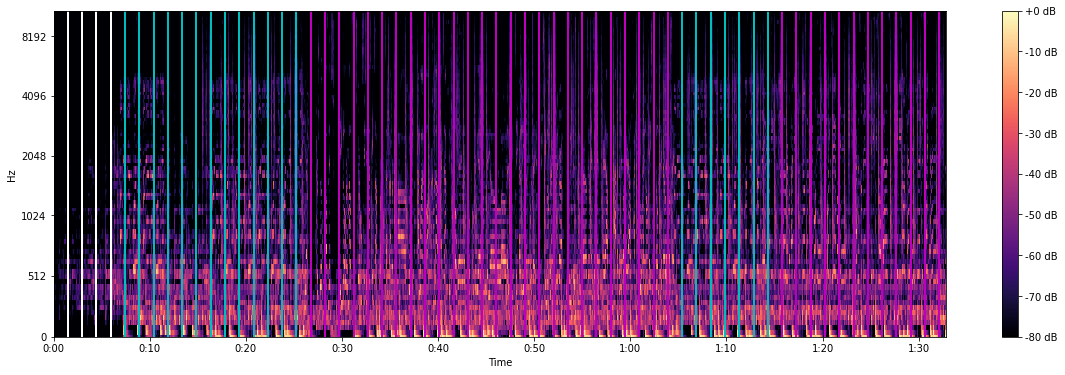

In [7]:
sr = 22050
stft_hop = 1024
chunk_len = cfg.CHUNK_LEN
hop_size = cfg.HOP_SIZE
bin_len = cfg.BIN_TIME_LEN

cut = 2000

dataset = HarmonixDataset()
dataloader = torch.utils.data.DataLoader(dataset)
iterator = iter(dataset)
song, labels = next(iterator)
cut_song = song[:, :cut]
cut_labels = labels[:cut]

#song, labels = song.squeeze(0), labels.squeeze(0)
times = (bin_len * chunk_len + 2 * np.arange(len(cut_labels)) * hop_size * bin_len) / 2

plt.rcParams['figure.figsize'] = (20, 6)
spec = librosa.amplitude_to_db(cut_song, ref=np.max)
img = librosa.display.specshow(spec, x_axis='time', y_axis='mel', sr=sr, hop_length=stft_hop)

color_dict = ('w', 'c', 'm', 'y', 'b', 'g', 'r')

for seg in list(set(cut_labels)):
  plt.vlines(times[cut_labels == seg], 0, sr/2, color=color_dict[seg])

plt.colorbar(format="%+2.f dB")
plt.show()

In [32]:
def split_chunk_with_hop(song):
  tensor_list = []
  start, end = 0, 0
  i = 0
  while end < song.shape[1]:
    start = i * cfg.HOP_SIZE
    end = start + cfg.CHUNK_LEN
    tensor_list.append(song[:, start:end])
    i += 1
  
  return torch.stack(tensor_list)

In [33]:
print(song.shape)
split_song = split_chunk_with_hop(song)
split_song.shape

torch.Size([80, 3360])


torch.Size([104, 80, 64])

# train

In [40]:
!nvidia-smi

Mon Feb 21 16:19:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!python "/content/drive/Othercomputers/MyEnvy/online-music-structure-segmentation/sup_train.py" --lr 0.01

2022-02-21 14:16:00-INFO-sup_train.py[37]-Start training!
2022-02-21 14:16:00-INFO-sup_train.py[38]-Namespace(batch_size=128, lr=0.01, model='unsup_embedding', n_epochs=200, pretrained=None)
  0% 0/912 [00:00<?, ?it/s]/content/drive/Othercomputers/MyEnvy/online-music-structure-segmentation/supervised_model/mss_data.py:59: FutureWarning: The default value of regex will change from True to False in a future version.
  labels = labels.str.replace('\d+', '')
Epoch:[0/200], loss=1.82023: 100% 912/912 [13:00<00:00,  1.17it/s]
2022-02-21 14:29:01-INFO-sup_train.py[115]-Epoch:[0/200]	 loss=1.81053	 score=0.000
Epoch:[1/200], loss=1.71509: 100% 912/912 [01:52<00:00,  8.07it/s]
2022-02-21 14:30:54-INFO-sup_train.py[115]-Epoch:[1/200]	 loss=1.80391	 score=0.000
Epoch:[2/200], loss=1.75893: 100% 912/912 [01:52<00:00,  8.13it/s]
2022-02-21 14:32:46-INFO-sup_train.py[115]-Epoch:[2/200]	 loss=1.80014	 score=0.000
Epoch:[3/200], loss=2.17058: 100% 912/912 [01:51<00:00,  8.15it/s]
2022-02-21 14:34:38-I

In [20]:
# remove dull experiments
import os, shutil
rp = '/content/drive/Othercomputers/MyEnvy/online-music-structure-segmentation/supervised_model/sup_experiments'
dirs = os.listdir(rp)
for d in dirs:
  exp_p = os.path.join(rp, d)
  if not os.path.isdir(exp_p):
    continue
  f_list = os.listdir(exp_p)
  if len(f_list) < 3:
    log_p = os.path.join(exp_p, 'train.log')
    f = open(log_p)
    lines = f.readlines()
    if len(lines) < 10:
      shutil.rmtree(exp_p)

# Eval

In [23]:
import msaf
from predict import predict_embedding
import numpy as np
import librosa.display
import librosa
import matplotlib.pyplot as plt
import os
from utils import config as cfg
import scipy

## visualize embedding

(128, 94)
(80, 3066)


Text(0.5, 1.0, 'Embedding')

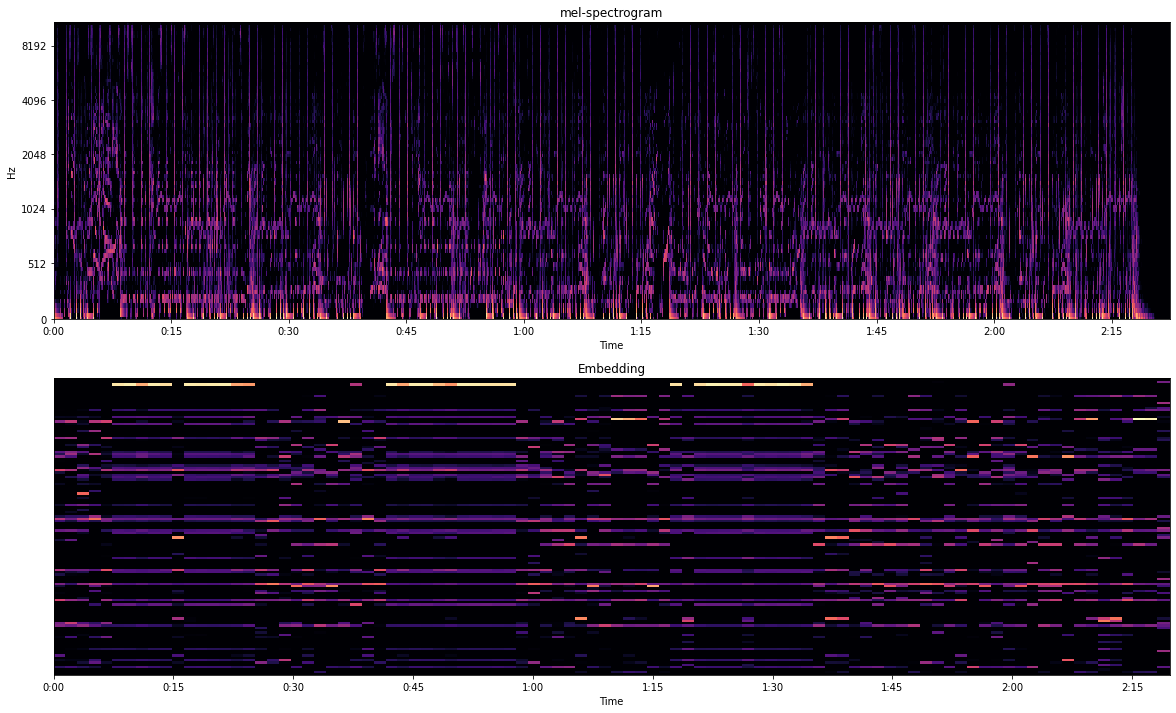

In [34]:
model_path = "/content/drive/Othercomputers/MyEnvy/online-music-structure-segmentation/supervised_model/sup_experiments/02210132/unsup_embedding_last.pt"
mel_path = '/content/drive/MyDrive/thesis/dataset/harmonixset-master/dataset/melspecs'
song = np.load(os.path.join(mel_path, '0001_12step-mel.npy'))
embedding = predict_embedding('unsup_embedding', model_path, song)
embedding = embedding.detach().numpy()
print(embedding.shape)
print(song.shape)

plt.rcParams['figure.figsize'] = (20, 12)
plt.subplot(2, 1, 1)
song = librosa.amplitude_to_db(song, ref=np.max)
librosa.display.specshow(song, hop_length=1024, x_axis='time', y_axis='mel')
plt.title('mel-spectrogram')
plt.subplot(2, 1, 2)
sr = 1 / (cfg.BIN_TIME_LEN)
img = librosa.display.specshow(embedding, sr=sr, hop_length=32, x_axis='time')
plt.title('Embedding')


/usr/local/lib/python3.7/dist-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.7/dist-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


Text(0.5, 1.0, 'SSM')

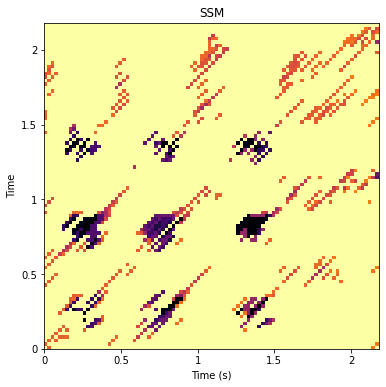

In [27]:
R = librosa.segment.recurrence_matrix(embedding, width=1, mode='affinity')
df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)
Rf = df(R, size=(1, 7))
plt.rcParams['figure.figsize'] = (6, 6)
librosa.display.specshow(Rf, cmap='inferno_r', y_axis='time', x_axis='s')
plt.title('SSM')

In [8]:
print(msaf.get_all_boundary_algorithms())

['example', 'olda', 'foote', 'vmo', 'sf', 'scluster', 'cnmf']


['fmc2d', 'vmo', 'scluster', 'cnmf']

In [ ]:
msaf.process(f)